FLIR Data

In [6]:
import zipfile
zip_path = "/home/deepaksr/project/project_assignment1/FLIR/FLIR.zip"
folder_path = "/home/deepaksr/project/project_assignment1/data4"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)
    
print(f"Data extracted to {folder_path}")

Data extracted to /home/deepaksr/project/project_assignment1/data4


Data Verification

In [2]:
import os

In [3]:
from PIL import Image # type: ignore

# Load the image
image = Image.open('/home/deepaksr/project/project_assignment1/data4/FLIR/Test/car/flir_20200116T174853.jpg')

# Get the mode of the image, which indicates the number of channels
print("Image mode:", image.mode)

# To get the number of channels directly
num_channels = len(image.getbands())
print("Number of channels:", num_channels)


Image mode: RGB
Number of channels: 3


In [4]:
import cv2 # type: ignore

# Load the image
image = cv2.imread('/home/deepaksr/project/project_assignment1/data4/FLIR/Test/car/flir_20200116T174853.jpg', -1)  # Load with all channels

# Get the shape of the image
print("Image shape:", image.shape)

# Number of channels is the last dimension
if len(image.shape) == 2:
    print("Number of channels: 1 (Grayscale)")
else:
    print(f"Number of channels: {image.shape[2]}")


Image shape: (1440, 1080, 3)
Number of channels: 3


In [5]:
train_path='/home/deepaksr/project/project_assignment1/data4/FLIR/Train'
#valid_path='/home/deepaksr/project/project_assignment1/data/valid'
test_path='/home/deepaksr/project/project_assignment1/data4/FLIR/Test'
def verify_data(folder):
  for classes in os.listdir(folder):
    class_path=os.path.join(folder,classes)
    if os.path.isdir(class_path):
      images = [i for i in os.listdir(class_path) if os.path.isfile(os.path.join(class_path,i))]
      counter = sum(1 for image in images if image.lower().endswith('.jpg'))
      print(f'class: {classes}')
      print(f'Images: {counter}\n')

print('Training Data:')
verify_data(train_path)
#print('Validation Data:')
#verify_data(valid_path)
print('Test Data:')
verify_data(test_path)

Training Data:
class: car
Images: 250

class: cat
Images: 272

class: man
Images: 289

Test Data:
class: car
Images: 147

class: cat
Images: 70

class: man
Images: 64



Data Augmentation using ImageDataGenerator & Data Generator using flow_from_directory 
(https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [6]:
import keras # type: ignore
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

2024-10-07 07:59:40.517656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 07:59:40.546784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 07:59:40.555705: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 07:59:40.573611: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-10-07 07:59:41.593591: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
datagen= ImageDataGenerator(rotation_range=10,width_shift_range=0.05,height_shift_range=0.05,
                            horizontal_flip=True, rescale=1.0/255, validation_split=0.1)
train_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            shuffle=True, subset='training')
val_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            shuffle=True, subset='validation')
test_generator = datagen.flow_from_directory(directory=test_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            shuffle=False)

print(train_generator.class_indices)
print(train_generator.samples)
print(val_generator.class_indices)
print(val_generator.samples)
print(test_generator.class_indices)
print(test_generator.samples)

Found 731 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
Found 281 images belonging to 3 classes.


{'car': 0, 'cat': 1, 'man': 2}
731
{'car': 0, 'cat': 1, 'man': 2}
80
{'car': 0, 'cat': 1, 'man': 2}
281


Checking Shape of loaded data batches

In [8]:
x_train_batch, y_train_batch = next(train_generator)
x_valid_batch, y_valid_batch = next(val_generator)
x_test_batch, y_test_batch = next(test_generator)

print(f"Training batch shape: {x_train_batch.shape}, Labels shape: {y_train_batch.shape}")
print(f"Validation batch shape: {x_valid_batch.shape}, Labels shape: {y_valid_batch.shape}")
print(f"Test batch shape: {x_test_batch.shape}, Labels shape: {y_test_batch.shape}")

Training batch shape: (8, 300, 300, 3), Labels shape: (8, 3)
Validation batch shape: (8, 300, 300, 3), Labels shape: (8, 3)
Test batch shape: (8, 300, 300, 3), Labels shape: (8, 3)


Classification using camera output images

Define the CNN using keras.models & keras.layers

In [9]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.utils import plot_model # type: ignore

In [10]:
def get_model():
  net = Sequential()
  net.add(Conv2D(32,(3,3), activation = 'relu', padding='same', input_shape=(300,300,3)))
  net.add(MaxPooling2D((2,2)))
  net.add(Conv2D(128,(3,3), activation='relu', padding='same'))
  net.add(MaxPooling2D((2,2)))
  net.add(Dropout(0.25))
  net.add(Flatten())
  #net.add(Dense(512, activation='relu'))
  net.add(Dense(128, activation='relu'))
  net.add(Dropout(0.25))
  net.add(Dense(3, activation='softmax'))
  net.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  return net

Plotting & visualising the Network

In [11]:
model=get_model()
model.summary()

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-07 07:59:59.012864: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9798 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 720000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    92,160,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,198,403 (351.71 MB)

 Trainable params: 92,198,403 (351.71 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(train_generator, validation_data=val_generator, epochs=35)

Epoch 1/35


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728268222.596117 1208200 service.cc:146] XLA service 0x7f8dcc00abc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728268222.596191 1208200 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-10-07 08:00:22.648358: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-07 08:00:22.896769: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907

 1/92 ━━━━━━━━━━━━━━━━━━━━ 11:46 8s/step - accuracy: 0.3750 - loss: 1.1101

I0000 00:00:1728268226.468200 1208200 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 329ms/step - accuracy: 0.4051 - loss: 5.5226 - val_accuracy: 0.6625 - val_loss: 0.9161
Epoch 2/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 287ms/step - accuracy: 0.4760 - loss: 1.0292 - val_accuracy: 0.7000 - val_loss: 0.9713
Epoch 3/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 283ms/step - accuracy: 0.5676 - loss: 0.9547 - val_accuracy: 0.6375 - val_loss: 0.8367
Epoch 4/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.7230 - loss: 0.7024 - val_accuracy: 0.5500 - val_loss: 0.8244
Epoch 5/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 284ms/step - accuracy: 0.7636 - loss: 0.6385 - val_accuracy: 0.7750 - val_loss: 0.6788
Epoch 6/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 282ms/step - accuracy: 0.7305 - loss: 0.6271 - val_accuracy: 0.6000 - val_loss: 0.9105
Epoch 7/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.8014 - loss: 0.4994 - val_accuracy: 0.6250 - val_loss: 0.7670
Epoch 8/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.8524 - loss: 0.3803 - val_accuracy: 0.775

In [13]:
history_dict = history.history

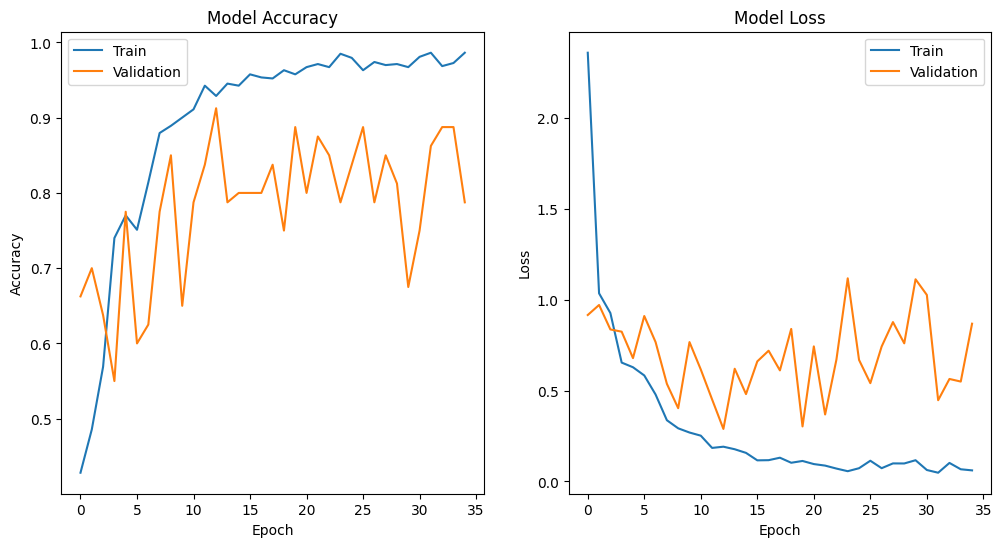

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

In [15]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step
[0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 0
 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [16]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.9146
Precision : 0.9217
Recall : 0.9146
F1 Score : 0.9150
Classification Report:
               precision    recall  f1-score   support

         car       0.96      0.88      0.92       147
         cat       0.82      1.00      0.90        70
         man       0.93      0.89      0.91        64

    accuracy                           0.91       281
   macro avg       0.91      0.92      0.91       281
weighted avg       0.92      0.91      0.92       281



In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[130  13   4]
 [  0  70   0]
 [  5   2  57]]


Classification using camera output images at larger size

Data Verification

In [18]:
import os

In [19]:
from PIL import Image # type: ignore

# Load the image
image = Image.open('/home/deepaksr/project/project_assignment1/data4/FLIR/Test/car/flir_20200116T174853.jpg')

# Get the mode of the image, which indicates the number of channels
print("Image mode:", image.mode)

# To get the number of channels directly
num_channels = len(image.getbands())
print("Number of channels:", num_channels)


Image mode: RGB
Number of channels: 3


In [20]:
import cv2 # type: ignore

# Load the image
image = cv2.imread('/home/deepaksr/project/project_assignment1/data4/FLIR/Test/car/flir_20200116T174853.jpg', -1)  # Load with all channels

# Get the shape of the image
print("Image shape:", image.shape)

# Number of channels is the last dimension
if len(image.shape) == 2:
    print("Number of channels: 1 (Grayscale)")
else:
    print(f"Number of channels: {image.shape[2]}")


Image shape: (1440, 1080, 3)
Number of channels: 3


In [21]:
train_path='/home/deepaksr/project/project_assignment1/data4/FLIR/Train'
#valid_path='/home/deepaksr/project/project_assignment1/data/valid'
test_path='/home/deepaksr/project/project_assignment1/data4/FLIR/Test'
def verify_data(folder):
  for classes in os.listdir(folder):
    class_path=os.path.join(folder,classes)
    if os.path.isdir(class_path):
      images = [i for i in os.listdir(class_path) if os.path.isfile(os.path.join(class_path,i))]
      counter = sum(1 for image in images if image.lower().endswith('.jpg'))
      print(f'class: {classes}')
      print(f'Images: {counter}\n')

print('Training Data:')
verify_data(train_path)
#print('Validation Data:')
#verify_data(valid_path)
print('Test Data:')
verify_data(test_path)

Training Data:
class: car
Images: 250

class: cat
Images: 272

class: man
Images: 289

Test Data:
class: car
Images: 147

class: cat
Images: 70

class: man
Images: 64



Data Augmentation using ImageDataGenerator & Data Generator using flow_from_directory 
(https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [22]:
import keras # type: ignore
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

In [23]:
datagen= ImageDataGenerator(rotation_range=10,width_shift_range=0.05,height_shift_range=0.05,
                            horizontal_flip=True, rescale=1.0/255, validation_split=0.1)
train_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(640,480),
                                            class_mode='categorical',
                                            batch_size=8,
                                            shuffle=True, subset='training')
val_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(640,480),
                                            class_mode='categorical',
                                            batch_size=8,
                                            shuffle=True, subset='validation')
test_generator = datagen.flow_from_directory(directory=test_path,
                                            target_size=(640,480),
                                            class_mode='categorical',
                                            batch_size=8,
                                            shuffle=False)

print(train_generator.class_indices)
print(train_generator.samples)
print(val_generator.class_indices)
print(val_generator.samples)
print(test_generator.class_indices)
print(test_generator.samples)

Found 731 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
Found 281 images belonging to 3 classes.


{'car': 0, 'cat': 1, 'man': 2}
731
{'car': 0, 'cat': 1, 'man': 2}
80
{'car': 0, 'cat': 1, 'man': 2}
281


Checking Shape of loaded data batches

In [24]:
x_train_batch, y_train_batch = next(train_generator)
x_valid_batch, y_valid_batch = next(val_generator)
x_test_batch, y_test_batch = next(test_generator)

print(f"Training batch shape: {x_train_batch.shape}, Labels shape: {y_train_batch.shape}")
print(f"Validation batch shape: {x_valid_batch.shape}, Labels shape: {y_valid_batch.shape}")
print(f"Test batch shape: {x_test_batch.shape}, Labels shape: {y_test_batch.shape}")

Training batch shape: (8, 640, 480, 3), Labels shape: (8, 3)
Validation batch shape: (8, 640, 480, 3), Labels shape: (8, 3)
Test batch shape: (8, 640, 480, 3), Labels shape: (8, 3)


Define the CNN using keras.models & keras.layers

In [25]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.utils import plot_model # type: ignore

In [26]:
def get_model():
  net = Sequential()
  net.add(Conv2D(32,(3,3), activation = 'relu', padding='same', input_shape=(640,480,3)))
  net.add(MaxPooling2D((2,2)))
  net.add(Conv2D(128,(3,3), activation='relu', padding='same'))
  net.add(MaxPooling2D((2,2)))
  net.add(Dropout(0.25))
  net.add(Flatten())
  #net.add(Dense(512, activation='relu'))
  net.add(Dense(128, activation='relu'))
  net.add(Dropout(0.25))
  net.add(Dense(3, activation='softmax'))
  net.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  return net

Plotting & visualising the Network

In [27]:
model=get_model()
model.summary()

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 640, 480, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 320, 240, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 320, 240, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 160, 120, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 160, 120, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2457600)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │   314,572,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,611,203 (1.17 GB)

 Trainable params: 314,611,203 (1.17 GB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(train_generator, validation_data=val_generator, epochs=35)

Epoch 1/35


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/92 ━━━━━━━━━━━━━━━━━━━━ 2s 580ms/step - accuracy: 0.4440 - loss: 14.2268

2024-10-07 08:20:10.948059: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.4508 - loss: 13.7156

2024-10-07 08:20:18.445599: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-07 08:20:18.759292: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


92/92 ━━━━━━━━━━━━━━━━━━━━ 78s 701ms/step - accuracy: 0.4521 - loss: 13.6190 - val_accuracy: 0.4250 - val_loss: 1.2460
Epoch 2/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 641ms/step - accuracy: 0.6998 - loss: 0.7596 - val_accuracy: 0.5250 - val_loss: 1.1243
Epoch 3/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 61s 615ms/step - accuracy: 0.7692 - loss: 0.6003 - val_accuracy: 0.5500 - val_loss: 1.0658
Epoch 4/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 63s 634ms/step - accuracy: 0.7969 - loss: 0.5452 - val_accuracy: 0.6500 - val_loss: 0.8024
Epoch 5/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 631ms/step - accuracy: 0.8308 - loss: 0.4648 - val_accuracy: 0.7125 - val_loss: 0.6755
Epoch 6/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 61s 620ms/step - accuracy: 0.8549 - loss: 0.4008 - val_accuracy: 0.5000 - val_loss: 1.1833
Epoch 7/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 640ms/step - accuracy: 0.8835 - loss: 0.3670 - val_accuracy: 0.6000 - val_loss: 1.8905
Epoch 8/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 631ms/step - accuracy: 0.8751 - loss: 0.3670 - val_accuracy: 0.67

In [29]:
history_dict = history.history

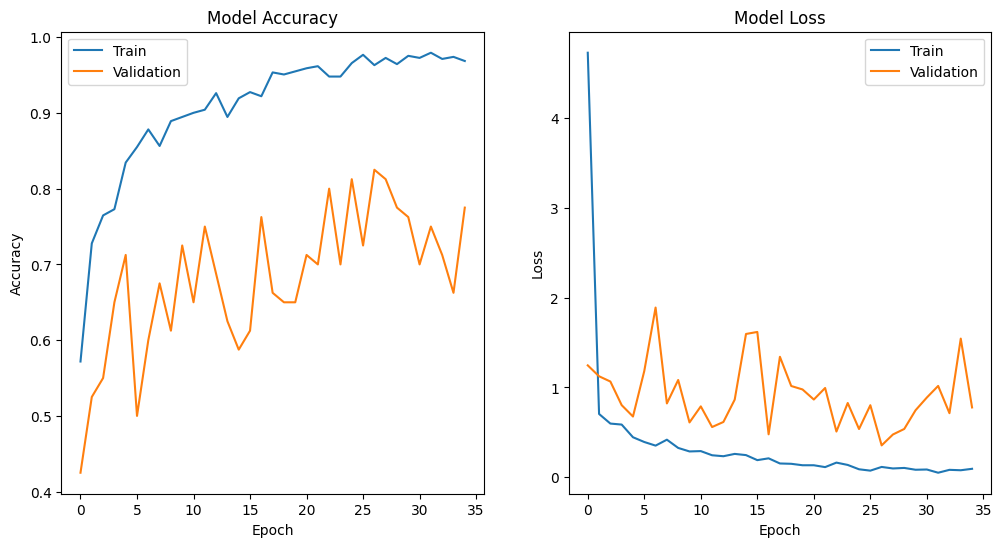

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

In [31]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 681ms/step
[0 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 2 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 1 1 0 0 0 0 0 0 0 0 0 0 2 0 1 1 1 1 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 1 2 2 2 2 2 2 2 0 2 2 0 0 0 0 2 0 2 2 0 0 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [32]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.8577
Precision : 0.8780
Recall : 0.8577
F1 Score : 0.8575
Classification Report:
               precision    recall  f1-score   support

         car       0.97      0.77      0.86       147
         cat       0.80      0.93      0.86        70
         man       0.76      0.98      0.86        64

    accuracy                           0.86       281
   macro avg       0.84      0.89      0.86       281
weighted avg       0.88      0.86      0.86       281



In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[113  15  19]
 [  4  65   1]
 [  0   1  63]]


Classification using single channel thermal images

Data Verification

In [34]:
import os

In [35]:
from PIL import Image # type: ignore

# Load the image
image = Image.open('/home/deepaksr/project/project_assignment1/data4/singlech/thermal_output/Test/car/flir_20200116T174848.jpg')

# Get the mode of the image, which indicates the number of channels
print("Image mode:", image.mode)

# To get the number of channels directly
num_channels = len(image.getbands())
print("Number of channels:", num_channels)


Image mode: L
Number of channels: 1


In [36]:
import cv2 # type: ignore

# Load the image
image = cv2.imread('/home/deepaksr/project/project_assignment1/data4/singlech/thermal_output/Test/car/flir_20200116T174848.jpg', -1)  # Load with all channels

# Get the shape of the image
print("Image shape:", image.shape)

# Number of channels is the last dimension
if len(image.shape) == 2:
    print("Number of channels: 1 (Grayscale)")
else:
    print(f"Number of channels: {image.shape[2]}")


Image shape: (640, 480)
Number of channels: 1 (Grayscale)


In [37]:
train_path='/home/deepaksr/project/project_assignment1/data4/singlech/thermal_output/Train'
#valid_path='/home/deepaksr/project/project_assignment1/data/valid'
test_path='/home/deepaksr/project/project_assignment1/data4/singlech/thermal_output/Test'
def verify_data(folder):
  for classes in os.listdir(folder):
    class_path=os.path.join(folder,classes)
    if os.path.isdir(class_path):
      images = [i for i in os.listdir(class_path) if os.path.isfile(os.path.join(class_path,i))]
      counter = sum(1 for image in images if image.lower().endswith('.jpg'))
      print(f'class: {classes}')
      print(f'Images: {counter}\n')

print('Training Data:')
verify_data(train_path)
#print('Validation Data:')
#verify_data(valid_path)
print('Test Data:')
verify_data(test_path)

Training Data:
class: car
Images: 250

class: cat
Images: 272

class: man
Images: 289

Test Data:
class: car
Images: 147

class: cat
Images: 70

class: man
Images: 64



Data Augmentation using ImageDataGenerator & Data Generator using flow_from_directory 
(https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [38]:
import keras # type: ignore
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

In [39]:
datagen= ImageDataGenerator(rotation_range=10,width_shift_range=0.05,height_shift_range=0.05,
                            horizontal_flip=True, rescale=1.0/255, validation_split=0.1)
train_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='grayscale',
                                            shuffle=True, subset='training')
val_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='grayscale',
                                            shuffle=True, subset='validation')
test_generator = datagen.flow_from_directory(directory=test_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='grayscale',
                                            shuffle=False)

print(train_generator.class_indices)
print(train_generator.samples)
print(val_generator.class_indices)
print(val_generator.samples)
print(test_generator.class_indices)
print(test_generator.samples)

Found 731 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
Found 281 images belonging to 3 classes.
{'car': 0, 'cat': 1, 'man': 2}
731
{'car': 0, 'cat': 1, 'man': 2}
80
{'car': 0, 'cat': 1, 'man': 2}
281


Checking Shape of loaded data batches

In [40]:
x_train_batch, y_train_batch = next(train_generator)
x_valid_batch, y_valid_batch = next(val_generator)
x_test_batch, y_test_batch = next(test_generator)

print(f"Training batch shape: {x_train_batch.shape}, Labels shape: {y_train_batch.shape}")
print(f"Validation batch shape: {x_valid_batch.shape}, Labels shape: {y_valid_batch.shape}")
print(f"Test batch shape: {x_test_batch.shape}, Labels shape: {y_test_batch.shape}")

Training batch shape: (8, 300, 300, 1), Labels shape: (8, 3)
Validation batch shape: (8, 300, 300, 1), Labels shape: (8, 3)
Test batch shape: (8, 300, 300, 1), Labels shape: (8, 3)


Define the CNN using keras.models & keras.layers

In [41]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.utils import plot_model # type: ignore

In [42]:
def get_model():
  net = Sequential()
  net.add(Conv2D(32,(3,3), activation = 'relu', padding='same', input_shape=(300,300,1)))
  net.add(MaxPooling2D((2,2)))
  net.add(Conv2D(128,(3,3), activation='relu', padding='same'))
  net.add(MaxPooling2D((2,2)))
  net.add(Dropout(0.25))
  net.add(Flatten())
  #net.add(Dense(512, activation='relu'))
  net.add(Dense(128, activation='relu'))
  net.add(Dropout(0.25))
  net.add(Dense(3, activation='softmax'))
  net.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  return net

Plotting & visualising the Network

In [43]:
model=get_model()
model.summary()

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 300, 300, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 150, 150, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 720000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    92,160,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,197,827 (351.71 MB)

 Trainable params: 92,197,827 (351.71 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
history = model.fit(train_generator, validation_data=val_generator, epochs=35)

Epoch 1/35


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.3935 - loss: 3.2573 - val_accuracy: 0.7125 - val_loss: 0.8646
Epoch 2/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.5967 - loss: 0.8922 - val_accuracy: 0.5625 - val_loss: 0.8414
Epoch 3/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.6438 - loss: 0.9154 - val_accuracy: 0.6375 - val_loss: 0.8791
Epoch 4/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.6883 - loss: 0.7616 - val_accuracy: 0.7875 - val_loss: 0.6170
Epoch 5/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.7408 - loss: 0.6270 - val_accuracy: 0.7000 - val_loss: 0.5810
Epoch 6/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.7619 - loss: 0.6033 - val_accuracy: 0.7625 - val_loss: 0.5997
Epoch 7/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.7779 - loss: 0.6190 - val_accuracy: 0.8125 - val_loss: 0.5092
Epoch 8/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.7964 - loss: 0.4854 - val_accuracy: 0.6625 - val_loss: 

In [45]:
history_dict = history.history

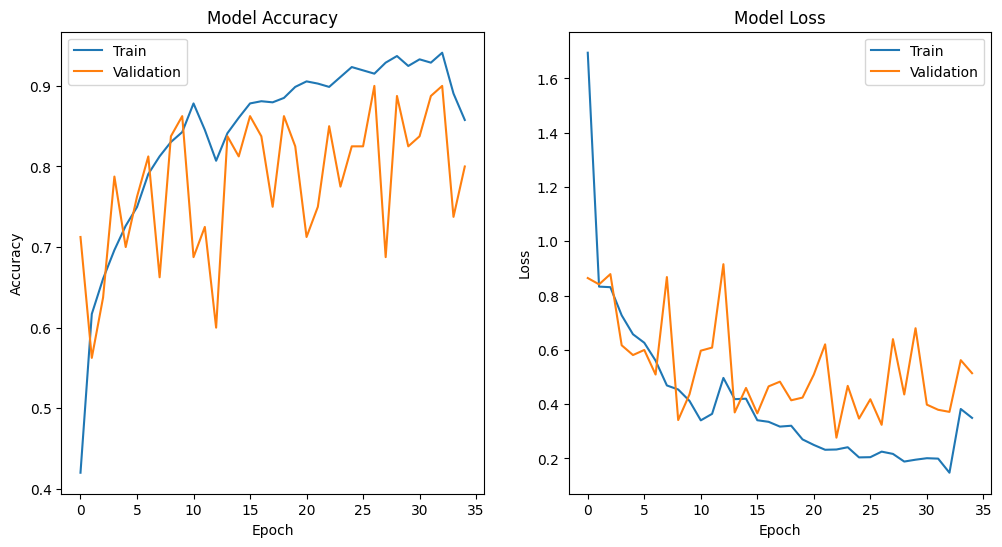

In [46]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

In [49]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
[1 1 1 2 2 2 2 2 2 2 2 0 0 0 2 2 0 0 1 1 1 2 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 2 0 0 2 2 2 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 1 2 2 1 1 1 1 2 2 2 2 0 0 0 0 2 2 1 1 0 1 0 2 0 1
 1 0 2 2 0 0 1 0 1 0 1 0 1 1 0 0 2 2 2 2 2 2 2 2 2 2 0 0 1 2 1 1 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 0 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [50]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.7189
Precision : 0.7953
Recall : 0.7189
F1 Score : 0.7134
Classification Report:
               precision    recall  f1-score   support

         car       0.95      0.54      0.69       147
         cat       0.68      0.96      0.79        70
         man       0.57      0.88      0.69        64

    accuracy                           0.72       281
   macro avg       0.73      0.79      0.72       281
weighted avg       0.80      0.72      0.71       281



In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[79 27 41]
 [ 1 67  2]
 [ 3  5 56]]


Classification using full size thermal data

Data Verification

In [52]:
import os

In [53]:
from PIL import Image # type: ignore

# Load the image
image = Image.open('/home/deepaksr/project/project_assignment1/data4/singlech/thermal_output/Test/man/flir_20200223T191105.jpg')

# Get the mode of the image, which indicates the number of channels
print("Image mode:", image.mode)

# To get the number of channels directly
num_channels = len(image.getbands())
print("Number of channels:", num_channels)


Image mode: L
Number of channels: 1


In [54]:
import cv2 # type: ignore

# Load the image
image = cv2.imread('/home/deepaksr/project/project_assignment1/data4/singlech/thermal_output/Test/man/flir_20200223T191105.jpg', -1)  # Load with all channels

# Get the shape of the image
print("Image shape:", image.shape)

# Number of channels is the last dimension
if len(image.shape) == 2:
    print("Number of channels: 1 (Grayscale)")
else:
    print(f"Number of channels: {image.shape[2]}")


Image shape: (640, 480)
Number of channels: 1 (Grayscale)


In [55]:
train_path='/home/deepaksr/project/project_assignment1/data4/singlech/thermal_output/Train'
#valid_path='/home/deepaksr/project/project_assignment1/data/valid'
test_path='/home/deepaksr/project/project_assignment1/data4/singlech/thermal_output/Test'
def verify_data(folder):
  for classes in os.listdir(folder):
    class_path=os.path.join(folder,classes)
    if os.path.isdir(class_path):
      images = [i for i in os.listdir(class_path) if os.path.isfile(os.path.join(class_path,i))]
      counter = sum(1 for image in images if image.lower().endswith('.jpg'))
      print(f'class: {classes}')
      print(f'Images: {counter}\n')

print('Training Data:')
verify_data(train_path)
#print('Validation Data:')
#verify_data(valid_path)
print('Test Data:')
verify_data(test_path)

Training Data:
class: car
Images: 250

class: cat
Images: 272

class: man
Images: 289

Test Data:
class: car
Images: 147

class: cat
Images: 70

class: man
Images: 64



Data Augmentation using ImageDataGenerator & Data Generator using flow_from_directory 
(https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [56]:
import keras # type: ignore
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

In [57]:
datagen= ImageDataGenerator(rotation_range=10,width_shift_range=0.05,height_shift_range=0.05,
                            horizontal_flip=True, rescale=1.0/255, validation_split=0.1)
train_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(640,480),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='grayscale',
                                            shuffle=True, subset='training')
val_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(640,480),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='grayscale',
                                            shuffle=True, subset='validation')
test_generator = datagen.flow_from_directory(directory=test_path,
                                            target_size=(640,480),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='grayscale',
                                            shuffle=False)

print(train_generator.class_indices)
print(train_generator.samples)
print(val_generator.class_indices)
print(val_generator.samples)
print(test_generator.class_indices)
print(test_generator.samples)

Found 731 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
Found 281 images belonging to 3 classes.
{'car': 0, 'cat': 1, 'man': 2}
731
{'car': 0, 'cat': 1, 'man': 2}
80
{'car': 0, 'cat': 1, 'man': 2}
281


Checking Shape of loaded data batches

In [58]:
x_train_batch, y_train_batch = next(train_generator)
x_valid_batch, y_valid_batch = next(val_generator)
x_test_batch, y_test_batch = next(test_generator)

print(f"Training batch shape: {x_train_batch.shape}, Labels shape: {y_train_batch.shape}")
print(f"Validation batch shape: {x_valid_batch.shape}, Labels shape: {y_valid_batch.shape}")
print(f"Test batch shape: {x_test_batch.shape}, Labels shape: {y_test_batch.shape}")

Training batch shape: (8, 640, 480, 1), Labels shape: (8, 3)
Validation batch shape: (8, 640, 480, 1), Labels shape: (8, 3)
Test batch shape: (8, 640, 480, 1), Labels shape: (8, 3)


Define the CNN using keras.models & keras.layers

In [59]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.utils import plot_model # type: ignore

In [60]:
def get_model():
  net = Sequential()
  net.add(Conv2D(16,(3,3), activation = 'relu', padding='same', input_shape=(640,480,1)))
  net.add(MaxPooling2D((2,2)))
  net.add(Conv2D(64,(3,3), activation='relu', padding='same'))
  net.add(MaxPooling2D((3,3)))
  net.add(Dropout(0.25))
  net.add(Flatten())
  #net.add(Dense(512, activation='relu'))
  net.add(Dense(128, activation='relu'))
  net.add(Dropout(0.25))
  net.add(Dense(3, activation='softmax'))
  net.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  return net

Plotting & visualising the Network

In [62]:
model=get_model()
model.summary()

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 640, 480, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 320, 240, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 320, 240, 64)   │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 106, 80, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 106, 80, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 542720)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    69,468,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,478,115 (265.04 MB)

 Trainable params: 69,478,115 (265.04 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
history = model.fit(train_generator, validation_data=val_generator, epochs=35)

Epoch 1/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.4700 - loss: 2.1713 - val_accuracy: 0.6000 - val_loss: 1.1186
Epoch 2/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.6094 - loss: 0.8981 - val_accuracy: 0.7375 - val_loss: 0.7715
Epoch 3/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - accuracy: 0.6437 - loss: 0.8166 - val_accuracy: 0.6875 - val_loss: 0.5901
Epoch 4/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.7119 - loss: 0.7092 - val_accuracy: 0.6500 - val_loss: 0.6433
Epoch 5/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - accuracy: 0.6843 - loss: 0.7240 - val_accuracy: 0.6750 - val_loss: 0.6531
Epoch 6/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.7134 - loss: 0.6400 - val_accuracy: 0.6875 - val_loss: 0.6382
Epoch 7/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.7394 - loss: 0.5766 - val_accuracy: 0.6375 - val_loss: 0.7056
Epoch 8/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - accuracy: 0.7659 - loss: 0.5661 - val_accu

In [65]:
history_dict = history.history

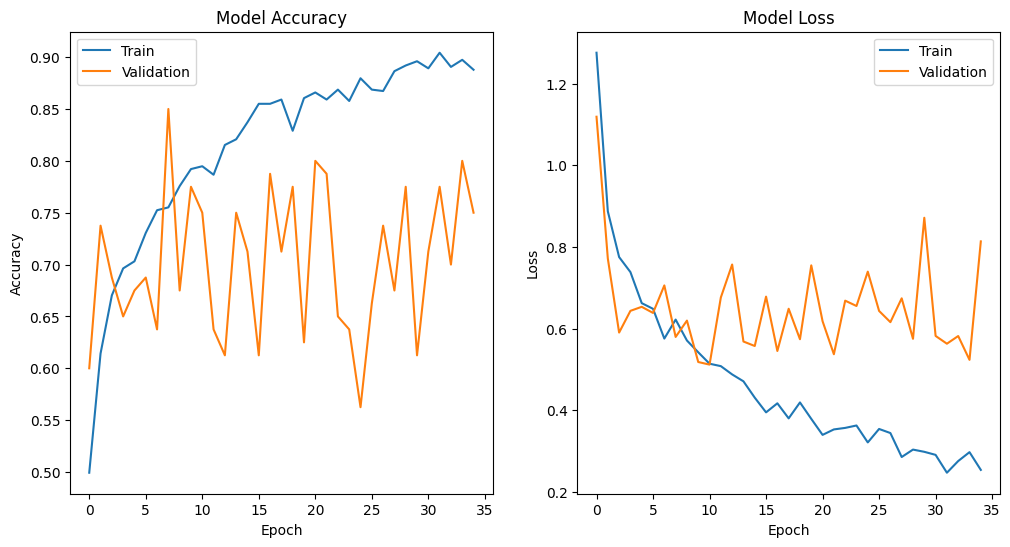

In [66]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

In [67]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step
[0 0 1 2 2 2 2 2 1 1 0 0 0 0 2 2 0 0 0 0 0 0 1 1 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0 0
 0 0 0 0 0 0 0 2 0 0 0 2 1 2 2 0 1 1 1 2 2 2 1 0 2 0 0 1 1 0 0 0 0 0 0 1 1
 2 2 2 2 0 0 0 0 0 1 1 1 0 0 1 1 2 2 2 2 2 2 2 2 0 0 0 0 1 1 1 1 2 0 2 2 1
 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 0
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [68]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.7331
Precision : 0.7997
Recall : 0.7331
F1 Score : 0.7306
Classification Report:
               precision    recall  f1-score   support

         car       0.94      0.57      0.71       147
         cat       0.70      0.91      0.80        70
         man       0.57      0.91      0.70        64

    accuracy                           0.73       281
   macro avg       0.74      0.80      0.74       281
weighted avg       0.80      0.73      0.73       281



In [70]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[84 23 40]
 [ 3 64  3]
 [ 2  4 58]]


Classification using 4 channel images with camera output and thermal data

Data Verification

In [1]:
import os

In [2]:
from PIL import Image # type: ignore

# Load the image
image = Image.open('/home/deepaksr/project/project_assignment1/data4/thermal_rgba_png_output/Test/cat/flir_20200203T125735.png')

# Get the mode of the image, which indicates the number of channels
print("Image mode:", image.mode)

# To get the number of channels directly
num_channels = len(image.getbands())
print("Number of channels:", num_channels)


Image mode: RGBA
Number of channels: 4


In [3]:
import cv2 # type: ignore

# Load the image
image = cv2.imread('/home/deepaksr/project/project_assignment1/data4/thermal_rgba_png_output/Test/cat/flir_20200203T125735.png', -1)  # Load with all channels

# Get the shape of the image
print("Image shape:", image.shape)

# Number of channels is the last dimension
if len(image.shape) == 2:
    print("Number of channels: 1 (Grayscale)")
else:
    print(f"Number of channels: {image.shape[2]}")


Image shape: (640, 480, 4)
Number of channels: 4


In [4]:
train_path='/home/deepaksr/project/project_assignment1/data4/thermal_rgba_png_output/Train'
#valid_path='/home/deepaksr/project/project_assignment1/data/valid'
test_path='/home/deepaksr/project/project_assignment1/data4/thermal_rgba_png_output/Test'
def verify_data(folder):
  for classes in os.listdir(folder):
    class_path=os.path.join(folder,classes)
    if os.path.isdir(class_path):
      images = [i for i in os.listdir(class_path) if os.path.isfile(os.path.join(class_path,i))]
      counter = sum(1 for image in images if image.lower().endswith('.png'))
      print(f'class: {classes}')
      print(f'Images: {counter}\n')

print('Training Data:')
verify_data(train_path)
#print('Validation Data:')
#verify_data(valid_path)
print('Test Data:')
verify_data(test_path)

Training Data:
class: car
Images: 250

class: cat
Images: 272

class: man
Images: 289

Test Data:
class: car
Images: 147

class: cat
Images: 70

class: man
Images: 64



Data Augmentation using ImageDataGenerator & Data Generator using flow_from_directory 
(https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [5]:
import keras # type: ignore
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

2024-10-07 10:21:19.015510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 10:21:19.036522: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 10:21:19.042883: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 10:21:19.059776: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 10:21:20.053597: W tensorflow/comp

In [6]:
datagen= ImageDataGenerator(rotation_range=10,width_shift_range=0.05,height_shift_range=0.05,
                            horizontal_flip=True, rescale=1.0/255, validation_split=0.1)
train_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='rgba',
                                            shuffle=True, subset='training')
val_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='rgba',
                                            shuffle=True, subset='validation')
test_generator = datagen.flow_from_directory(directory=test_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='rgba',
                                            shuffle=False)

print(train_generator.class_indices)
print(train_generator.samples)
print(val_generator.class_indices)
print(val_generator.samples)
print(test_generator.class_indices)
print(test_generator.samples)

Found 731 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
Found 281 images belonging to 3 classes.
{'car': 0, 'cat': 1, 'man': 2}
731
{'car': 0, 'cat': 1, 'man': 2}
80
{'car': 0, 'cat': 1, 'man': 2}
281


Checking Shape of loaded data batches

In [7]:
x_train_batch, y_train_batch = next(train_generator)
x_valid_batch, y_valid_batch = next(val_generator)
x_test_batch, y_test_batch = next(test_generator)

print(f"Training batch shape: {x_train_batch.shape}, Labels shape: {y_train_batch.shape}")
print(f"Validation batch shape: {x_valid_batch.shape}, Labels shape: {y_valid_batch.shape}")
print(f"Test batch shape: {x_test_batch.shape}, Labels shape: {y_test_batch.shape}")

Training batch shape: (8, 300, 300, 4), Labels shape: (8, 3)
Validation batch shape: (8, 300, 300, 4), Labels shape: (8, 3)
Test batch shape: (8, 300, 300, 4), Labels shape: (8, 3)


Define the CNN using keras.models & keras.layers

In [8]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.utils import plot_model # type: ignore

In [9]:
def get_model():
  net = Sequential()
  net.add(Conv2D(32,(3,3), activation = 'relu', padding='same', input_shape=(300,300,4)))
  net.add(MaxPooling2D((2,2)))
  net.add(Conv2D(128,(3,3), activation='relu', padding='same'))
  net.add(MaxPooling2D((2,2)))
  net.add(Dropout(0.25))
  net.add(Flatten())
  #net.add(Dense(512, activation='relu'))
  net.add(Dense(128, activation='relu'))
  net.add(Dropout(0.25))
  net.add(Dense(3, activation='softmax'))
  net.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  return net

Plotting & visualising the Network

In [10]:
model=get_model()
model.summary()

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-07 10:21:37.071587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9798 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2024-10-07 10:21:37.072504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9798 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2024-10-07 10:21:37.073190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 300, 300, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 720000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    92,160,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,198,691 (351.71 MB)

 Trainable params: 92,198,691 (351.71 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(train_generator, validation_data=val_generator, epochs=35)

Epoch 1/35


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728276704.713213 1245949 service.cc:146] XLA service 0x7fd3e8009d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728276704.713275 1245949 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1728276704.713298 1245949 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1728276704.713317 1245949 service.cc:154]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1728276704.713331 124

 1/92 ━━━━━━━━━━━━━━━━━━━━ 11:41 8s/step - accuracy: 0.2500 - loss: 1.1155

I0000 00:00:1728276708.638680 1245949 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 316ms/step - accuracy: 0.4025 - loss: 7.1367 - val_accuracy: 0.6000 - val_loss: 0.8778
Epoch 2/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 270ms/step - accuracy: 0.7493 - loss: 0.7967 - val_accuracy: 0.6000 - val_loss: 0.8750
Epoch 3/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 266ms/step - accuracy: 0.6850 - loss: 0.7453 - val_accuracy: 0.8500 - val_loss: 0.6080
Epoch 4/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.7249 - loss: 0.7073 - val_accuracy: 0.7000 - val_loss: 0.5951
Epoch 5/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.7996 - loss: 0.5463 - val_accuracy: 0.7500 - val_loss: 0.6639
Epoch 6/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.8276 - loss: 0.4338 - val_accuracy: 0.8375 - val_loss: 0.3717
Epoch 7/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 265ms/step - accuracy: 0.8681 - loss: 0.4028 - val_accuracy: 0.8375 - val_loss: 0.4404
Epoch 8/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 261ms/step - accuracy: 0.8713 - loss: 0.3528 - val_accuracy: 0.775

In [12]:
history_dict = history.history

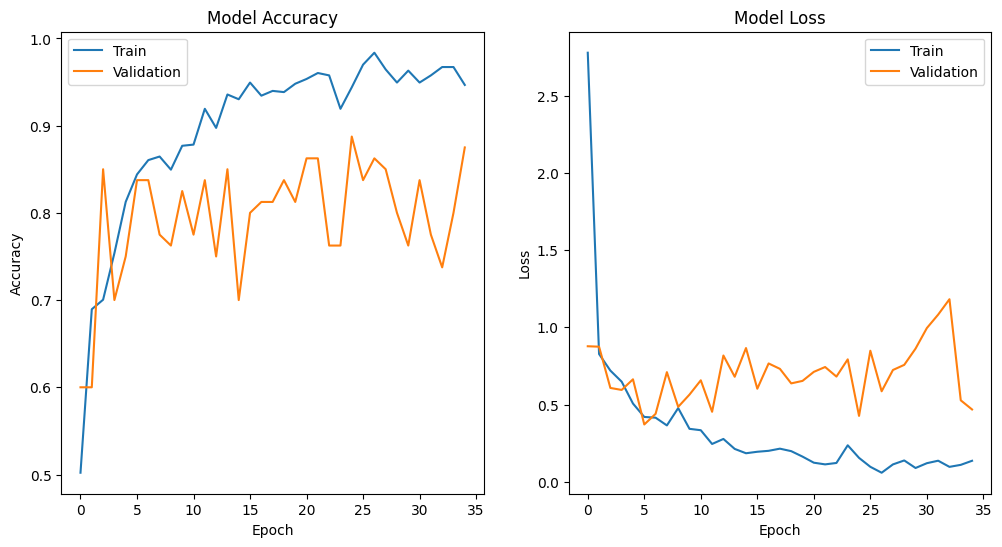

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

In [14]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 286ms/step
[0 0 1 2 2 0 2 2 0 0 2 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0 0
 0 0 0 0 0 2 2 2 0 0 2 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2
 0 2 0 0 0 0 0 0 0 1 1 0 0 1 0 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [15]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.8648
Precision : 0.8972
Recall : 0.8648
F1 Score : 0.8670
Classification Report:
               precision    recall  f1-score   support

         car       0.98      0.76      0.86       147
         cat       0.92      0.97      0.94        70
         man       0.68      0.98      0.80        64

    accuracy                           0.86       281
   macro avg       0.86      0.91      0.87       281
weighted avg       0.90      0.86      0.87       281



In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[112   6  29]
 [  1  68   1]
 [  1   0  63]]


Classification using full size 4 channel images

Data Verification

In [17]:
import os

In [18]:
from PIL import Image # type: ignore

# Load the image
image = Image.open('/home/deepaksr/project/project_assignment1/data4/thermal_rgba_png_output/Test/car/flir_20200116T174911.png')

# Get the mode of the image, which indicates the number of channels
print("Image mode:", image.mode)

# To get the number of channels directly
num_channels = len(image.getbands())
print("Number of channels:", num_channels)


Image mode: RGBA
Number of channels: 4


In [19]:
import cv2 # type: ignore

# Load the image
image = cv2.imread('/home/deepaksr/project/project_assignment1/data4/thermal_rgba_png_output/Test/car/flir_20200116T174911.png', -1)  # Load with all channels

# Get the shape of the image
print("Image shape:", image.shape)

# Number of channels is the last dimension
if len(image.shape) == 2:
    print("Number of channels: 1 (Grayscale)")
else:
    print(f"Number of channels: {image.shape[2]}")


Image shape: (640, 480, 4)
Number of channels: 4


In [20]:
train_path='/home/deepaksr/project/project_assignment1/data4/thermal_rgba_png_output/Train'
#valid_path='/home/deepaksr/project/project_assignment1/data/valid'
test_path='/home/deepaksr/project/project_assignment1/data4/thermal_rgba_png_output/Test'
def verify_data(folder):
  for classes in os.listdir(folder):
    class_path=os.path.join(folder,classes)
    if os.path.isdir(class_path):
      images = [i for i in os.listdir(class_path) if os.path.isfile(os.path.join(class_path,i))]
      counter = sum(1 for image in images if image.lower().endswith('.png'))
      print(f'class: {classes}')
      print(f'Images: {counter}\n')

print('Training Data:')
verify_data(train_path)
#print('Validation Data:')
#verify_data(valid_path)
print('Test Data:')
verify_data(test_path)

Training Data:
class: car
Images: 250

class: cat
Images: 272

class: man
Images: 289

Test Data:
class: car
Images: 147

class: cat
Images: 70

class: man
Images: 64



Data Augmentation using ImageDataGenerator & Data Generator using flow_from_directory 
(https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [21]:
import keras # type: ignore
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

In [22]:
datagen= ImageDataGenerator(rotation_range=10,width_shift_range=0.05,height_shift_range=0.05,
                            horizontal_flip=True, rescale=1.0/255, validation_split=0.1)
train_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(640,480),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='rgba',
                                            shuffle=True, subset='training')
val_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(640,480),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='rgba',
                                            shuffle=True, subset='validation')
test_generator = datagen.flow_from_directory(directory=test_path,
                                            target_size=(640,480),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='rgba',
                                            shuffle=False)

print(train_generator.class_indices)
print(train_generator.samples)
print(val_generator.class_indices)
print(val_generator.samples)
print(test_generator.class_indices)
print(test_generator.samples)

Found 731 images belonging to 3 classes.
Found 80 images belonging to 3 classes.


Found 281 images belonging to 3 classes.
{'car': 0, 'cat': 1, 'man': 2}
731
{'car': 0, 'cat': 1, 'man': 2}
80
{'car': 0, 'cat': 1, 'man': 2}
281


Checking Shape of loaded data batches

In [23]:
x_train_batch, y_train_batch = next(train_generator)
x_valid_batch, y_valid_batch = next(val_generator)
x_test_batch, y_test_batch = next(test_generator)

print(f"Training batch shape: {x_train_batch.shape}, Labels shape: {y_train_batch.shape}")
print(f"Validation batch shape: {x_valid_batch.shape}, Labels shape: {y_valid_batch.shape}")
print(f"Test batch shape: {x_test_batch.shape}, Labels shape: {y_test_batch.shape}")

Training batch shape: (8, 640, 480, 4), Labels shape: (8, 3)
Validation batch shape: (8, 640, 480, 4), Labels shape: (8, 3)
Test batch shape: (8, 640, 480, 4), Labels shape: (8, 3)


Define the CNN using keras.models & keras.layers

In [24]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.utils import plot_model # type: ignore

In [25]:
def get_model():
  net = Sequential()
  net.add(Conv2D(32,(3,3), activation = 'relu', padding='same', input_shape=(640,480,4)))
  net.add(MaxPooling2D((2,2)))
  net.add(Conv2D(128,(3,3), activation='relu', padding='same'))
  net.add(MaxPooling2D((2,2)))
  net.add(Dropout(0.25))
  net.add(Flatten())
  #net.add(Dense(512, activation='relu'))
  net.add(Dense(128, activation='relu'))
  net.add(Dropout(0.25))
  net.add(Dense(3, activation='softmax'))
  net.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  return net

Plotting & visualising the Network

In [26]:
model=get_model()
model.summary()

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 640, 480, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 320, 240, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 320, 240, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 160, 120, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 160, 120, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2457600)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │   314,572,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,611,491 (1.17 GB)

 Trainable params: 314,611,491 (1.17 GB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(train_generator, validation_data=val_generator, epochs=35)

Epoch 1/35


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/92 ━━━━━━━━━━━━━━━━━━━━ 8s 724ms/step - accuracy: 0.4146 - loss: 16.7707

2024-10-07 11:16:58.696889: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.4266 - loss: 15.3132

2024-10-07 11:17:08.840668: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-07 11:17:09.092303: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 831ms/step - accuracy: 0.4275 - loss: 15.2056 - val_accuracy: 0.6250 - val_loss: 0.7927
Epoch 2/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 761ms/step - accuracy: 0.6458 - loss: 0.9471 - val_accuracy: 0.6375 - val_loss: 0.7553
Epoch 3/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 773ms/step - accuracy: 0.5999 - loss: 0.8548 - val_accuracy: 0.7625 - val_loss: 0.5964
Epoch 4/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 773ms/step - accuracy: 0.6828 - loss: 0.7478 - val_accuracy: 0.6500 - val_loss: 0.7313
Epoch 5/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 776ms/step - accuracy: 0.7378 - loss: 0.6841 - val_accuracy: 0.6250 - val_loss: 0.7774
Epoch 6/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 776ms/step - accuracy: 0.7243 - loss: 0.7387 - val_accuracy: 0.7750 - val_loss: 0.5337
Epoch 7/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 774ms/step - accuracy: 0.8413 - loss: 0.4897 - val_accuracy: 0.7750 - val_loss: 0.7529
Epoch 8/35
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 777ms/step - accuracy: 0.8227 - loss: 0.4771 - val_accuracy: 0.85

In [28]:
history_dict = history.history

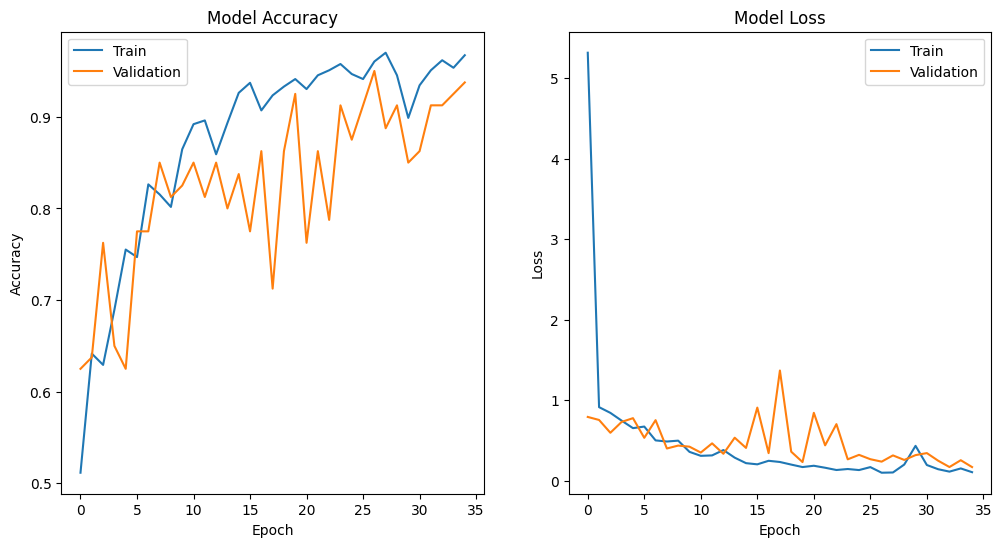

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

In [30]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 813ms/step
[0 0 1 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 1 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 1 0 2 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 2 0 0 0 0 1
 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 2 2 2 2 0 2 0 0 0 0 0 0 1 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [31]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.8683
Precision : 0.8855
Recall : 0.8683
F1 Score : 0.8680
Classification Report:
               precision    recall  f1-score   support

         car       0.97      0.78      0.86       147
         cat       0.78      0.97      0.87        70
         man       0.81      0.95      0.88        64

    accuracy                           0.87       281
   macro avg       0.85      0.90      0.87       281
weighted avg       0.89      0.87      0.87       281



In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[115  19  13]
 [  1  68   1]
 [  3   0  61]]
